In [1]:
#make sure that we're in a notebook that is running in a calour environment
import os
print(os.environ['CONDA_DEFAULT_ENV'])
%matplotlib notebook
#%matplotlib inline

base


In [2]:
import calour as ca
ca.set_log_level(11)
import numpy as np
np.random.seed(2018)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
import calour.training
from calour.training import plot_scatter, plot_roc, plot_cm, plot_prc
import scipy.sparse

import pandas as pd
import numpy as np
import biom
import os
from io import StringIO
import glob
import biom
from biom import Table
from biom.util import biom_open 
import matplotlib.pyplot as plt
#import seaborn as sns
import pathlib
from pathlib import Path
import matplotlib
%matplotlib inline
from scipy.stats import linregress
from itertools import combinations
from scipy.stats import ttest_ind

In [3]:
def save_biom_from_tsv(tsv_filename,author='default'):
    #http://biom-format.org/documentation/generated/biom.table.Table.from_tsv.html#biom.table.Table.from_tsv
    fp= open(tsv_filename)
    stasis_func = lambda x : x 
    temp_table =biom.Table.from_tsv(fp, None, None, stasis_func)
    save_biom(tsv_filename[:-4]+'.biom',temp_table,author)

def save_biom(biom_filename, biom_table,author='default'):
    with biom_open(biom_filename, 'w') as f:  
            biom_table.to_hdf5(f, author)
    print("Saved to " + biom_filename)

In [4]:
#start off by seeing what's in this directory
!ls

11872_20181004-103322.txt
11872_20181004-103322_valid_diet.tsv
20190319_calour_example_cheetahs_diet.ipynb
METABOLOMICS-SNETS-0416a28a-download_cluster_buckettable-main.tsv


In [5]:
#have a look at our feature table to make sure the format is sample names as columns, features as rows
bucket_filepath_tsv = 'METABOLOMICS-SNETS-0416a28a-download_cluster_buckettable-main.tsv'
!head $bucket_filepath_tsv

#OTU ID	G85325_RA7_01_36750	G84934_RB3_01_36904	G84740_RH5_01_36553	G85281_RE10_01_36805	G84906_GE2_01_36859	G85268_RD9_01_36789	G79474_5x_RD10_01_18108	G84943_RA8_01_36897	G84904_RG2_01_36959	G85214_BF3_01_36716	G85187_GB3_01_36832	G85285_RB9_01_36765	G85351_GA3_01_36823	G85217_RB12_01_37024	G85016_BH6_01_36660	G85417_RF10_01_36817	G84873_RD6_01_36932	G72746_10x_3ul_BB3_01_17887	G84955_BH10_01_36664	G84721_RC8_01_36492	G84752_RB3_01_37016	G84854_GB8_01_36838	G85048_RH9_01_36557	G85392_RF3_01_37061	G84857_RE9_01_36944	G84693_RE4_01_36940	G84925_RF10_01_36534	G84708_BC11_01_36601	G84760_RH10_01_36558	G79346_5x_rerun_BB7_01_19392	G79612_5x_RA5_01_18348	G84902_BC3_01_36593	G85013_RG5_01_36869	G84852_RB2_01_36903	G85012_BF3_01_37162	G85393_rerun_gas_BD5_01_37221	G85003_RF6_01_37064	G85035_RA8_01_37009	G85370_RE4_01_36799	G84750_BA6_01_37105	G84764_BD3_01_36707	G85030_RC5_01_37028	G85231_BH2_01_36724	G85051_RC10_01_36494	G84780_RB10_01_37022	G85389_RF7_01_36953	G79573_5x_RF2_01_18231	G84784

In [6]:
#have a look at the metadata to make sure it is formatted as expected
md = pd.read_table('11872_20181004-103322.txt')
md.head()

,sample_name,accession_no,age,age_units,animal_name,antibiotic_use,body_habitat,body_product,body_site,clns_testing,...,taxon_id,time_feces,time_feces_collected,time_feces_sampled,time_of_day_feces_collected,time_point,time_point_units,time_to_process,time_to_process_units,title
0,11872.BLANK1.1D,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,...,256318,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,SD Cheetahs
1,11872.BLANK1.1E,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,...,256318,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,SD Cheetahs
2,11872.BLANK1.1F,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,...,256318,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,SD Cheetahs
3,11872.BLANK1.1G,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,...,256318,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,SD Cheetahs
4,11872.BLANK1.1H,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,...,256318,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,SD Cheetahs


In [7]:
#find the food samples
samples_of_interest_only = md[md['description'].str.contains('diet')]
samples_of_interest_only.head()

,sample_name,accession_no,age,age_units,animal_name,antibiotic_use,body_habitat,body_product,body_site,clns_testing,...,taxon_id,time_feces,time_feces_collected,time_feces_sampled,time_of_day_feces_collected,time_point,time_point_units,time_to_process,time_to_process_units,title
534,11872.G85336,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,...,870729,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,SD Cheetahs
535,11872.G85337,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,...,870728,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,not applicable,SD Cheetahs


In [8]:
#import the raw bucket table; N.B. update this to take biom and refactor filtering using biom commands later
raw_bucket = pd.read_table(bucket_filepath_tsv)

#these steps are only needed because there is not a match between the metadata sample_names and the columns in the bucket table
#start by extracting all samples, skipping the feature column name
samples= pd.Series(raw_bucket.columns.drop(['#OTU ID']))

#because these are GFoP samples, the first 6 digits should be able to map to Qiita metadata
samples = samples.apply(lambda x: str(11872)+"." +x[:6])
indexed_bucket = raw_bucket.set_index('#OTU ID')
indexed_bucket.columns = samples.tolist()

#converting a bucket table to biom will have issues if there are duplicates so remove
indexed_bucket = indexed_bucket.loc[:,~indexed_bucket.columns.duplicated()]#for now drop all duplicates

In [9]:
#make sure the table came out as expected
indexed_bucket.head()

,11872.G85325,11872.G84934,11872.G84740,11872.G85281,11872.G84906,11872.G85268,11872.G79474,11872.G84943,11872.G84904,11872.G85214,...,11872.G84993,11872.G85205,11872.G84866,11872.G85303,11872.G84911,11872.G84927,11872.G85381,11872.G85263,11872.G85337,11872.G85054
#OTU ID,,,,,,,,,,,,,,,,,,,,,
64510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69377,0.0,0.0,0.0,0.0,0.0,0.0,7876.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3723.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
#now let's start getting the list of food-related features
#get the list of food samples based on the searching above
food_samples=samples_of_interest_only['sample_name']

#create a subset table with just the food samples
food_subset= indexed_bucket[food_samples]

#only keep features where present in at least one of the samples
#note: to get features unique to a sample, a different exclusion method will be needed
food_subset = food_subset.loc[(food_subset!=0).any(axis=1)]
food_features = food_subset.index.tolist()

In [13]:
#make sure the resulting table makes sense
food_subset.head()

,11872.G85336,11872.G85337
#OTU ID,,
26909,2047.0,0.0
60300,1941.0,0.0
58933,2133.0,0.0
74332,16200.0,0.0
50383,0.0,4266.0


In [14]:
#pull out all the non-food samples which will be used for ML
non_food_bucket = indexed_bucket.drop(food_samples,axis=1)

#drop all the features from these samples not found in the food samples
non_food_with_food_features =non_food_bucket[non_food_bucket.index.isin(food_features)]

In [15]:
#since doing this with tsv instead of biom but need biom, this is the way to go from a dataframe to a biom table for now
non_food_with_food_features.to_csv('20190319_bucket_table_qiita_names_food_only.tsv',sep='\t',header=True,index=True,index_label='#OTU ID')
save_biom_from_tsv('20190319_bucket_table_qiita_names_food_only.tsv',author='calour')

Saved to 20190319_bucket_table_qiita_names_food_only.biom


In [17]:
#to look at presence/absence in addition to abundance information, especially since data isn't normalized we have to convert
to_norm_table = biom.load_table('20190319_bucket_table_qiita_names_food_only.biom')
save_biom('20190319_bucket_table_qiita_names_food_only_pa.biom',to_norm_table.pa(),author='calour')

Saved to 20190319_bucket_table_qiita_names_food_only_pa.biom


Everything above here was to get the data into a suitable format for ML
If the bucket to biom table already has been performed such that there are matching IDs with the metadata and the table has bee filtered then you only need to start here
There is a biom-based version of filtering to use in the future in lieu of the above

In [18]:
#find the metadata columns of interest
print(md.columns[md.columns.str.contains('diet')])

Index(['day_of_diet_transition', 'diet_beef_quantity',
       'diet_beef_quantity_units', 'diet_composition', 'diet_consumption',
       'diet_horse_quantity', 'diet_horse_quantity_units', 'diet_intervention',
       'diet_offered'],
      dtype='object')


In [19]:
#look at the values in the relevant column
md.groupby(['diet_composition'])['host_subject_id'].count()

diet_composition
beef              281
horse              73
horse_beef        167
horse_rabbit        2
not applicable     77
not provided       10
rabbit              9
shank              12
Name: host_subject_id, dtype: int64

In [20]:
#define the metdata category to do ML prediction with
food_field='diet_composition'

#define the cateogires in the above field to look at
food_categories=['beef','horse','horse_beef']

In [21]:
md = md[md[food_field].isin(food_categories)]
md.to_csv('11872_20181004-103322_valid_diet.tsv',sep='\t',header=True,index=False)

In [22]:
#note this section uses ms data as if it were ASV data which means some of calour won't work
#calour assumes for ms data it will be in some special tsv format with a companion file of IDs so for metabolomics data
#you may not want to always use biom tables, but importantly there is nothing wrong with doing the ML this way

#create the calour experiment object
ms=ca.read_amplicon('20190319_bucket_table_qiita_names_food_only.biom','11872_20181004-103322_valid_diet.tsv',
                    normalize=None,min_reads=0)

2019-03-19 23:41:14 INFO loaded 585 samples, 390 features
2019-03-19 23:41:15 WARNING These have metadata but do not have data - dropped (10): {'11872.G85367', '11872.G85383', '11872.G84916', '11872.G85288', '11872.G84859', '11872.G85408', '11872.G84987', '11872.G84692', '11872.G84694', '11872.G84921'}
2019-03-19 23:41:15 WARNING These have data but do not have metadata: {'11872.G79479', '11872.G79346', '11872.G79555', '11872.G84866', '11872.G84992', '11872.G84997', '11872.G84991', '11872.G79343', '11872.G85188', '11872.G85187', '11872.G79578', '11872.G79608', '11872.G84955', '11872.G79350', '11872.G79347', '11872.G79342', '11872.G84928', '11872.G84910', '11872.G84996', '11872.G79349', '11872.G79612', '11872.G84977', '11872.G84906', '11872.G84865', '11872.G72765', '11872.G84876', '11872.G84998', '11872.G72801', '11872.G84985', '11872.G84886', '11872.G79348', '11872.G72746', '11872.G84897', '11872.G79602', '11872.G79680', '11872.G79553', '11872.G84909', '11872.G84994', '11872.G79480', '

In [23]:
#because biom table is superset of metadata, filter out any nans
ms=ms.filter_by_metadata(field=food_field,select=None)

In [29]:
#filter out samples not related to the food categories of interest
ms=ms.filter_by_metadata(field=food_field,select=food_categories)

In [34]:
it = calour.training.classify(ms,food_field, RandomForestClassifier(random_state=13), cv=RepeatedStratifiedKFold(10, 10), predict='predict_proba',params=[{'n_estimators':20}, {'n_estimators': 200}])

In [35]:
#the results are in series so extract and preview
res1 = next(it)
res1.head()

,beef,horse,horse_beef,Y_TRUE,SAMPLE,CV
0,0.45,0.10,0.45,beef,11872.G85325,0
1,0.60,0.15,0.25,horse_beef,11872.G85048,0
2,0.55,0.00,0.45,beef,11872.G84760,0
3,0.15,0.35,0.50,horse,11872.G84852,0
4,0.25,0.05,0.70,horse_beef,11872.G85233,0


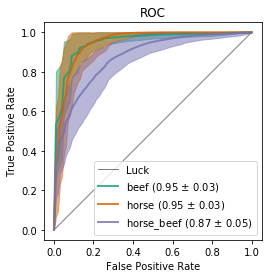

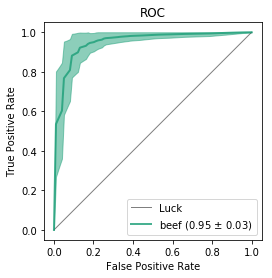

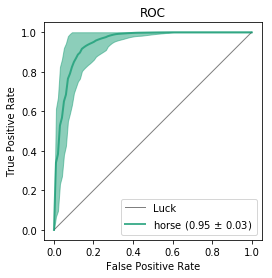

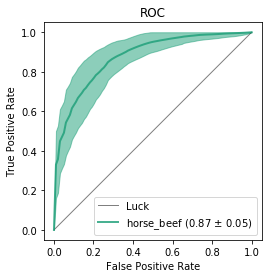

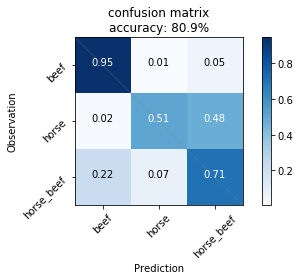

In [36]:
#graph the results, change roc to aupr if concerned about imbalanced data
plot_roc(res1, classes=food_categories)
for food in food_categories:
    plot_roc(res1, classes=[food])
plot_cm(res1, normalize=True)

In [37]:
#grab the results of the second parameter set
res2 = next(it)
res2.head()

,beef,horse,horse_beef,Y_TRUE,SAMPLE,CV
0,0.080,0.515,0.405,horse,11872.G84873,0
1,0.240,0.145,0.615,horse_beef,11872.G85013,0
2,0.135,0.505,0.360,horse,11872.G84861,0
3,0.160,0.550,0.290,horse,11872.G84862,0
4,0.190,0.175,0.635,horse_beef,11872.G85041,0


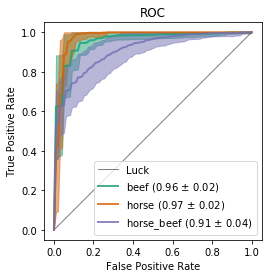

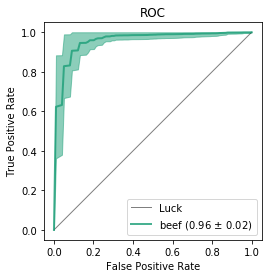

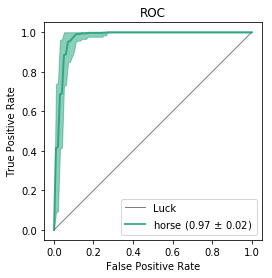

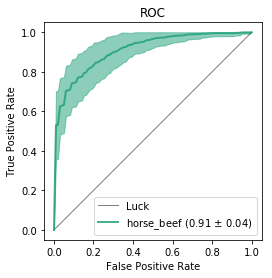

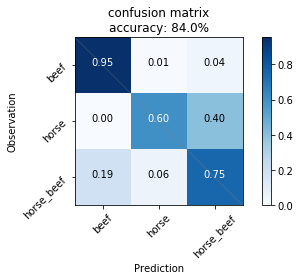

In [38]:
#graph the second parameter set result as before
plot_roc(res2, classes=food_categories)
for food in food_categories:
    plot_roc(res2, classes=[food])
plot_cm(res2, normalize=True)

In [46]:
#repeat the above using the presence/absence table
ms_pa=ca.read_amplicon('20190319_bucket_table_qiita_names_food_only_pa.biom','11872_20181004-103322_valid_diet.tsv',
                    normalize=None,min_reads=0)

2019-03-19 23:45:07 INFO loaded 585 samples, 390 features
2019-03-19 23:45:07 WARNING These have metadata but do not have data - dropped (10): {'11872.G85367', '11872.G85383', '11872.G84916', '11872.G85288', '11872.G84859', '11872.G85408', '11872.G84987', '11872.G84692', '11872.G84694', '11872.G84921'}
2019-03-19 23:45:07 WARNING These have data but do not have metadata: {'11872.G79479', '11872.G79346', '11872.G79555', '11872.G84866', '11872.G84992', '11872.G84997', '11872.G84991', '11872.G79343', '11872.G85188', '11872.G85187', '11872.G79578', '11872.G79608', '11872.G84955', '11872.G79350', '11872.G79347', '11872.G79342', '11872.G84928', '11872.G84910', '11872.G84996', '11872.G79349', '11872.G79612', '11872.G84977', '11872.G84906', '11872.G84865', '11872.G72765', '11872.G84876', '11872.G84998', '11872.G72801', '11872.G84985', '11872.G84886', '11872.G79348', '11872.G72746', '11872.G84897', '11872.G79602', '11872.G79680', '11872.G79553', '11872.G84909', '11872.G84994', '11872.G79480', '

In [47]:
#because biom table is superset of metadata, filter out any nans
ms_pa=ms_pa.filter_by_metadata(field=food_field,select=None)

In [48]:
#filter out samples not related to the food categories of interest
ms_pa=ms_pa.filter_by_metadata(field=food_field,select=food_categories)

In [49]:
it_pa = calour.training.classify(ms_pa,food_field, RandomForestClassifier(random_state=13), cv=RepeatedStratifiedKFold(10, 10), predict='predict_proba',params=[{'n_estimators':20}, {'n_estimators': 200}])

In [50]:
res1_pa = next(it_pa)
print(res1_pa.head())


   beef  horse  horse_beef      Y_TRUE        SAMPLE  CV
0  0.05   0.45         0.5  horse_beef  11872.G84934   0
1  0.90   0.00         0.1        beef  11872.G84943   0
2  1.00   0.00         0.0        beef  11872.G84721   0
3  0.40   0.00         0.6  horse_beef  11872.G84984   0
4  0.80   0.00         0.2        beef  11872.G84744   0


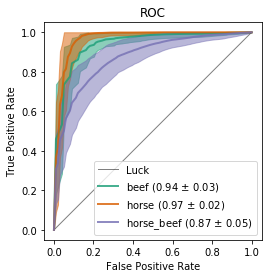

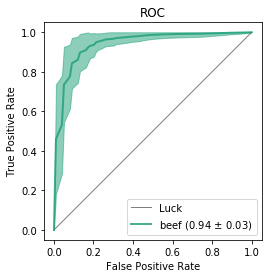

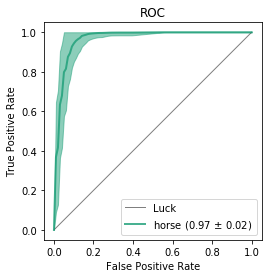

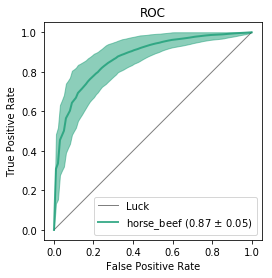

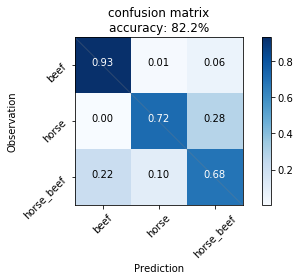

In [51]:
plot_roc(res1_pa, classes=food_categories)
for food in food_categories:
    plot_roc(res1_pa, classes=[food])
plot_cm(res1_pa, normalize=True)

In [52]:
res2_pa = next(it_pa)
print(res2_pa.head())

    beef  horse  horse_beef      Y_TRUE        SAMPLE  CV
0  0.945  0.005       0.050        beef  11872.G84740   0
1  0.755  0.025       0.220        beef  11872.G84943   0
2  0.630  0.025       0.345        beef  11872.G85214   0
3  0.375  0.050       0.575  horse_beef  11872.G85285   0
4  0.645  0.010       0.345  horse_beef  11872.G85417   0


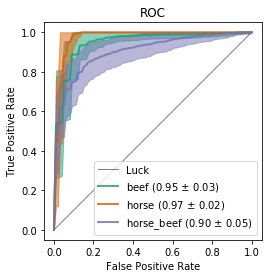

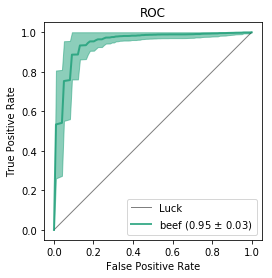

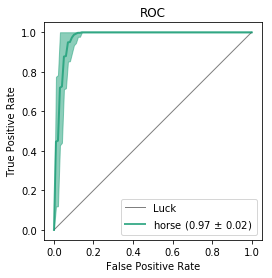

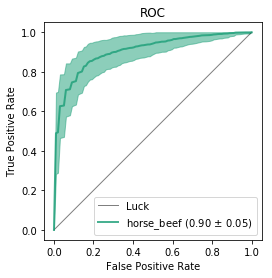

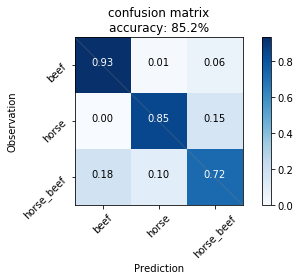

In [53]:
plot_roc(res2_pa, classes=food_categories)
for food in food_categories:
    plot_roc(res2_pa, classes=[food])
plot_cm(res2_pa, normalize=True)

In [ ]:
#there wasn't a way in calour to view feature importances easily, so I tried to create one below by modifying
#the native function to return a dictionary. It's a bit of a kludge, and can be improved by someone else, especially since
#it doesn't precisely give the desired information
#the confusion matrix appears to be a summary of all of the predictions rather than the 'best'
#therefore there likely needs to be input from someone who understands ML better to advise on how to see which ones were most
#important and whether or not there is a proper way to choose from amongst the models 

In [70]:
from sklearn.model_selection._split import check_cv, _RepeatedSplits
from sklearn.base import is_classifier, clone
from logging import getLogger
import itertools
logger = getLogger(__name__)
def alt_classify(exp, fields, estimator, cv=RepeatedStratifiedKFold(3, 1),
             predict='predict_proba', params=None):
    '''Evaluate classification during cross validation.
    Parameters
    ----------
    fields : str or list of str
        column name(s) in the sample metadata, which contains the classes we want to predict.
        If it is a list of str, this function does multi-task (aka multioutput-multiclass)
        classification and you must provide an `estimator` of multi-task classifier. See
        `http://scikit-learn.org/stable/modules/multiclass.html` for more information.
    estimator : estimator object implementing `fit` and `predict`
        scikit-learn estimator. e.g. :class:`sklearn.ensemble.RandomForestClassifer`
    cv : int, cross-validation generator or an iterable
        similar to the `cv` parameter in :class:`sklearn.model_selection.GridSearchCV`
    predict : {'predict', 'predict_proba'}
        the function used to predict the validation sets. Some estimators
        have both functions to predict class or predict the probablity of each class
        for a sample. For example, see :class:`sklearn.ensemble.RandomForestClassifier`
    params : dict of string to sequence, or sequence of such
        For example, the output of
        :class:`sklearn.model_selection.ParameterGrid` or
        :class:`sklearn.model_selection.ParameterSampler`. By default,
        it uses whatever default parameters of the `estimator` set in
        `scikit-learn`
    Yields
    ------
    pandas.DataFrame
        The result of prediction per sample for a given parameter set. It contains the
        following columns:
        - Y_TRUE: the true class for the samples
        - SAMPLE: sample IDs
        - CV: which split of the cross validation
        - Y_PRED: the predicted class for the samples (if "predict")
        - mutliple columns with each contain probabilities predicted as each class (if "predict_proba")
    '''
    X = exp.data
    y = exp.sample_metadata[fields]
    cv = check_cv(cv, y, classifier=is_classifier(estimator))

    if params is None:
        # use sklearn default param values for the given estimator
        params = [{}]
    count=0
    for param in params:
        logger.debug('run classification with parameters: %r' % param)
        model_df_dict = {}
        for i, (train, test) in enumerate(cv.split(X, y)):
            # deep copy the model by clone to avoid the impact from last iteration of fit.
            model = clone(estimator)
            model = model.set_params(**param)
            model.fit(X[train], y[train])
            pred = getattr(model, predict)(X[test])
            if pred.ndim > 1:
                df = pd.DataFrame(pred, columns=model.classes_)
            else:
                df = pd.DataFrame(pred, columns=['Y_PRED'])
            df['Y_TRUE'] = y[test].values
            df['SAMPLE'] = y[test].index.values
            df['CV'] = i
            model_df_dict[count] = df,model
            count += 1
        yield model_df_dict

In [71]:
#using the alt function returns not only the dataframes of predictions, but also the 
test_results = alt_classify(ms_pa,food_field, RandomForestClassifier(random_state=13), cv=RepeatedStratifiedKFold(10, 10), predict='predict_proba',params=[{'n_estimators':20}, {'n_estimators': 200}])

In [72]:
test1=next(test_results)


In [106]:
test1[30][0]

,beef,horse,horse_beef,Y_TRUE,SAMPLE,CV
0,0.45,0.05,0.50,horse_beef,11872.G85285,30
1,0.60,0.00,0.40,horse_beef,11872.G85417,30
2,0.10,0.65,0.25,horse,11872.G84857,30
3,0.10,0.65,0.25,horse,11872.G84852,30
4,0.40,0.05,0.55,horse_beef,11872.G85030,30
5,0.25,0.30,0.45,horse_beef,11872.G84930,30
6,1.00,0.00,0.00,beef,11872.G84917,30
7,1.00,0.00,0.00,beef,11872.G85222,30
8,0.30,0.25,0.45,horse_beef,11872.G85185,30
9,0.30,0.10,0.60,horse_beef,11872.G84983,30


In [91]:
feature_importances = pd.DataFrame(test1[0][1].feature_importances_,index=ms_pa.feature_metadata.index,
                                   columns=['importance']).sort_values('importance',ascending=[False])

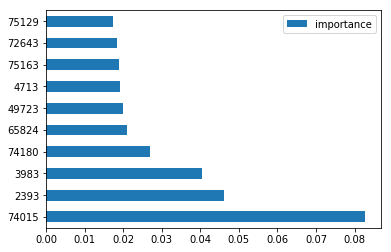

In [97]:
feature_importances.nlargest(10, columns='importance').plot(kind='barh')

In [107]:
res1.tail()

,beef,horse,horse_beef,Y_TRUE,SAMPLE,CV
5105,0.70,0.00,0.30,horse_beef,11872.G85208,99
5106,0.95,0.00,0.05,beef,11872.G84697,99
5107,0.05,0.45,0.50,horse_beef,11872.G85218,99
5108,0.55,0.20,0.25,horse_beef,11872.G84935,99
5109,0.25,0.20,0.55,horse_beef,11872.G85212,99


   beef  horse  horse_beef      Y_TRUE        SAMPLE  CV
0  0.45   0.10        0.45        beef  11872.G85325   0
1  0.60   0.15        0.25  horse_beef  11872.G85048   0
2  0.55   0.00        0.45        beef  11872.G84760   0
3  0.15   0.35        0.50       horse  11872.G84852   0
4  0.25   0.05        0.70  horse_beef  11872.G85233   0
['beef', 'beef', 'beef', 'horse_beef', 'horse_beef']


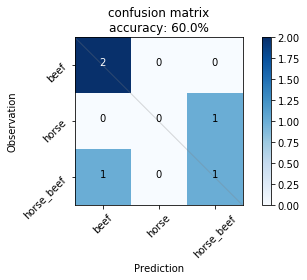

In [128]:
from sklearn.metrics import confusion_matrix
plot_cm_alt(res1.head(5))

In [127]:
def plot_cm_alt(result, normalize=False, title='confusion matrix', cmap=None, ax=None, classes=None, **kwargs):
    '''Plot confusion matrix
    Parameters
    ----------
    result : pandas.DataFrame
        data frame containing predictions per sample (in row). It must have a column of
        true class named "Y_TRUE". It must have a column of predicted class named "Y_PRED"
        or multiple columns of predicted probabilities for each class. It typically takes
        the output of :func:`classify`.
    normalize : bool
        normalize the confusion matrix or not
    title : str
        plot title
    cmap : str or matplotlib.colors.ListedColormap
        str to indicate the colormap name. Default is "Blues" colormap.
        For all available colormaps in matplotlib: https://matplotlib.org/users/colormaps.html
    ax : matplotlib.axes.Axes or None (default), optional
        The axes where the confusion matrix is plotted. None (default) to create a new figure and
        axes to plot the confusion matrix
    classes : list
        The list of the labels you want to include in the plot in the order specified in the list.
    kwargs : dict
        keyword argument passing to :func:`matplotlib.pyplot.imshow`. For example, you can pass
        `vmin=0, vmax=1` as keyword arguments to manually define color range (especially useful
        when you set `normalize=True`)
    Returns
    -------
    matplotlib.axes.Axes
        The axes for the confusion matrix
    '''
    from matplotlib import pyplot as plt
    if cmap is None:
        cmap = plt.cm.Blues
    # if labels is given, use it (and its order); otherwise:
    if classes is None:
        classes = np.unique(result['Y_TRUE'].values)
        classes.sort()

    cm = _compute_cm_alt(result, labels=classes)
    accuracy = cm.trace() / cm.sum()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        logger.debug("Normalized confusion matrix")
    else:
        logger.debug('Confusion matrix, without normalization')
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    img = ax.imshow(cm, cmap=cmap, **kwargs)
    ax.set_title('{0}\naccuracy: {1:.1%}'.format(title, accuracy))
    fig.colorbar(img)
    tick_marks = np.arange(len(classes))
    ax.tick_params(rotation=45)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    # plot a diagonal line
    ax.plot([0, 1], [1, 0], alpha=0.3, color='gray', linewidth=1, transform=ax.transAxes)

    ax.set_ylabel('Observation')
    ax.set_xlabel('Prediction')
    # disable grid explicitly because seaborn default style plot grid
    # lines, which is very disturbing
    ax.grid(False)
    fig.tight_layout()
    return ax


def _compute_cm_alt(result, labels, **kwargs):
    print(result.head(5))
    if 'Y_PRED' not in result.columns:
        idx = np.argmax(result[labels].values, axis=1)
        y_pred = [labels[i] for i in idx]
        print(y_pred)
    else:
        y_pred = result['Y_PRED']
        print(y_pred)
    return confusion_matrix(result['Y_TRUE'], y_pred, labels=labels, **kwargs)